<a href="https://colab.research.google.com/github/martinloretzzz/polynomial-mlp/blob/main/polynomial_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomials as weights and activations for MLP's

### Blog post: [martinloretz.com/blog/polynomial-mlp/](https://martinloretz.com/blog/polynomial-mlp/)
Read the blog post first to understand what's happening here.

Parts of the code from [github.com/CSCfi/machine-learning-scripts](https://github.com/CSCfi/machine-learning-scripts/blob/master/notebooks/pytorch-mnist-mlp.ipynb)
and  [How to Build Your Own PyTorch Neural Network Layer from Scratch](https://hackernoon.com/how-to-build-your-own-pytorch-neural-network-layer-from-scratch-2x6136th)

In [1]:
!pip install wandb -qU

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import wandb

import numpy as np
import matplotlib.pyplot as plt
import os
import math

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.2.1+cu121
Using GPU, device name: Tesla T4


In [3]:
wandb.login()

wandb: Currently logged in as: martinloretzzz. Use `wandb login --relogin` to force relogin


True

### Data

In [4]:
batch_size = 2048

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST('./data', train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)

(60000, 10000)

data: torch.Size([2048, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([2048]) type: torch.LongTensor


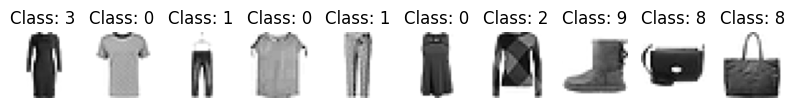

In [5]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

### Test/Train Loop

In [6]:
def correct(output, target):
    predicted_digits = output.argmax(1)
    correct_ones = (predicted_digits == target).type(torch.float)
    return correct_ones.sum().item()

In [7]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss, total_correct = 0, 0
    for data, target in data_loader:
        data, target = data.to(device),  target.to(device)

        output = model(data)

        loss = criterion(output, target)
        total_loss += loss
        total_correct += correct(output, target)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Train: Average loss: {train_loss:7f}, accuracy: {100*accuracy:>0.1f}")
    return train_loss, accuracy

In [8]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss, total_correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device),  target.to(device)

            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()

            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Test: Average loss: {test_loss:7f}, accuracy: {100*accuracy:>0.1f}")
    return test_loss, accuracy

### Linear reference model

In [9]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 20),
            nn.ReLU(),
            nn.LayerNorm(20),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

SimpleMLP()

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)

### Polynomial model

In [10]:
def calculate_input_powers(input, degree=3):
    batch_size = input.size(0)
    powers = torch.arange(2, degree + 1, device=input.device).unsqueeze(0)

    input_tensor = input.unsqueeze(2).expand(batch_size, -1, degree - 1)
    powered_input_tensor = torch.pow(input_tensor, powers)

    ones_column = torch.ones(batch_size, input.size(1), dtype=input.dtype, device=input.device)
    return torch.cat((ones_column.unsqueeze(2), input.unsqueeze(2), powered_input_tensor), dim=-1)

calculate_input_powers(torch.tensor([[1, 2, 3, 4]]), degree=5)

tensor([[[   1,    1,    1,    1,    1,    1],
         [   1,    2,    4,    8,   16,   32],
         [   1,    3,    9,   27,   81,  243],
         [   1,    4,   16,   64,  256, 1024]]])

In [11]:
class PolynomialLayer(nn.Module):
    def __init__(self, in_features, out_features, polynomial_degree, dense=True):
        super().__init__()
        self.dense = dense # A fully connected layer if dense=True else it elementwise
        self.in_features = in_features
        self.out_features = out_features
        self.polynomial_degree = polynomial_degree
        self.weight = torch.nn.Parameter(torch.zeros(out_features if dense else 1, in_features, polynomial_degree+1))
        self.reset_parameters()

    def reset_parameters(self):
        # TODO better weight initialization
        bound = 0.01
        for deg in range(self.polynomial_degree + 1):
          scale = (1.0 / (deg**2)) if deg > 1 else 1.0
          nn.init.uniform_(self.weight[:, :, deg], -bound * scale, bound * scale)

    def forward(self, input):
        bs, y = input.shape
        if y != self.in_features:
            raise Exception(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')

        input_powers = calculate_input_powers(input, degree=self.polynomial_degree)

        if self.dense:
            input_view = input_powers.view(bs, self.in_features * (self.polynomial_degree+1))
            weight_view = self.weight.view(self.out_features, self.in_features * (self.polynomial_degree+1))
            output = input_view.matmul(weight_view.t())
        else:
            output = torch.mul(input_powers, self.weight).sum(-1)

        return output

    def extra_repr(self):
        return 'in_features={}, out_features={}, polynomial_degree={}, dense={}'.format(
            self.in_features, self.out_features, self.polynomial_degree, self.dense
        )

class PolynomialMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            PolynomialLayer(28*28, 20, polynomial_degree=3),
            nn.LayerNorm(20),
            PolynomialLayer(20, 10, polynomial_degree=3),
            # PolynomialLayer(10, 10, polynomial_degree=3, dense=False) # Output activations
        )

    def forward(self, x):
        return self.layers(x)

model = PolynomialMLP().to(device)

data = torch.randn(batch_size, 28, 28, device=device)
model(data)

model

PolynomialMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): PolynomialLayer(in_features=784, out_features=20, polynomial_degree=3, dense=True)
    (2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (3): PolynomialLayer(in_features=20, out_features=10, polynomial_degree=3, dense=True)
  )
)

### Model training

In [ ]:
%%time

def train_model(train_model, epochs=50, name="poly"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(train_model.parameters(), lr=1e-1)

    total_params = sum(p.numel() for p in train_model.parameters())
    print(f"Number of parameters of {name}: {total_params}")

    model_metadata = {"type": name, "epochs": epochs, "dataset": "FashionMNIST", "params": total_params}
    wandb.init(project="polynomial-mlp", name=f"e-{name}-x", config=model_metadata)

    for epoch in range(epochs):
        print(f"Training epoch: {epoch}")
        train_loss, train_accurcy = train(train_loader, train_model, criterion, optimizer)
        wandb.log({"epoch":epoch, "train/acc": train_accurcy, "train/loss": train_loss})
        test_loss, test_accurcy = test(test_loader, train_model, criterion)
        wandb.log({"epoch":epoch, "test/acc": test_accurcy, "test/loss": test_loss})
    wandb.finish()

model = PolynomialMLP().to(device)
model_linear = SimpleMLP().to(device)

train_model(model, epochs=50, name="poly")
train_model(model_linear, epochs=50, name="lin")

Number of parameters of poly: 63560


Training epoch: 0
Train: Average loss: 3.290150, accuracy: 17.1
Test: Average loss: 1.865423, accuracy: 23.6
Training epoch: 1
Train: Average loss: 1.339484, accuracy: 48.3
Test: Average loss: 1.010376, accuracy: 61.8
Training epoch: 2
Train: Average loss: 0.823993, accuracy: 70.3
Test: Average loss: 0.746436, accuracy: 70.7
Training epoch: 3
Train: Average loss: 0.677564, accuracy: 74.6
Test: Average loss: 0.631307, accuracy: 76.8
Training epoch: 4
Train: Average loss: 0.589375, accuracy: 78.4
Test: Average loss: 0.640467, accuracy: 75.4
Training epoch: 5
Train: Average loss: 0.574351, accuracy: 78.9
Test: Average loss: 0.564184, accuracy: 80.1
Training epoch: 6
Train: Average loss: 0.528517, accuracy: 80.8
Test: Average loss: 0.548421, accuracy: 79.8
Training epoch: 7
Train: Average loss: 0.511213, accuracy: 81.3
Test: Average loss: 0.538060, accuracy: 80.3
Training epoch: 8
Train: Average loss: 0.487152, accuracy: 82.3
Test: Average loss: 0.523616, accuracy: 81.0
Training epoch: 9
T